In [1]:
# pip install torch torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.utils as vutils
import torch.nn as nn
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from loss_functions import CombinedLoss
from discriminator_model import DiscriminatorModel
from upscaling_model import UpscalingModel
from data_sets_loaders import get_train_val_test_dataloaders
import os

%matplotlib inline

In [2]:
def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    plt.imshow(np.transpose(vutils.make_grid(x[:4].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()


def train_prototype(train_dl, val_dl, num_epochs=5, learning_rate=1e-4):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    discriminator_model = DiscriminatorModel(3, 8, 0.3).to(device)
    upscaling_model = UpscalingModel(3, 3, 3, 32, 10).to(device)

    discriminator_params = torch.cat([x.view(-1) for x in discriminator_model.parameters()])

    upscaling_model.to(device)
    discriminator_model.to(device)
    upscaling_model.train()
    discriminator_model.train()

    torch.manual_seed(42)
    criterion = CombinedLoss(0.0, 1.0, 1.0, 0.0, 100.0, device=device)
    optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=learning_rate) 
    optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate) 
    
    iters, train_losses, val_losses = [], [], []
    n = 0
    for epoch in range(num_epochs):

        if epoch == 2:
            criterion = CombinedLoss(0.1, 1.0, 1.0, 0.5, 100.0, device=device)
            optimizer_upscale = torch.optim.Adam(upscaling_model.parameters(), lr=learning_rate) 
            optimizer_discriminator = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate) 

        train_count    = 0
        val_count      = 0
        train_loss_sum = 0
        val_loss_sum   = 0

        num_batches = len(train_dl)
        for batch_i, (inputs_lr, targets_hr) in enumerate(train_dl):

            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)

            real_labels = torch.ones(inputs_lr.shape[0], 1).to(device)
            generated_labels = torch.zeros(inputs_lr.shape[0], 1).to(device)

            # Update Discriminator
            real_outputs = discriminator_model(targets_hr)
            discriminator_loss_real = criterion(None, real_labels, real_outputs, is_discriminator=True)

            generated_hr = upscaling_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr.detach())
            discriminator_loss_generated = criterion(None, generated_labels, generated_outputs, is_discriminator=True)

            discriminator_reg_l2 = 1.0 * torch.mean((discriminator_params)**2)
            discriminator_reg_l1 = 1.0 * torch.mean(torch.abs(discriminator_params))
            discriminator_reg = discriminator_reg_l2 + discriminator_reg_l1
            discriminator_loss = discriminator_loss_real + discriminator_loss_generated + discriminator_reg

            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Update Generator
            generated_outputs = discriminator_model(targets_hr)
            generator_loss = criterion(generated_hr, targets_hr, generated_outputs)

            optimizer_upscale.zero_grad()
            generator_loss.backward()
            optimizer_upscale.step()

            train_loss_sum += generator_loss.item()
            train_count += 1

            if (batch_i+1) % 20 == 0:
                print(f"Batch {batch_i+1}/{num_batches}, generator loss {generator_loss.item()}, discriminator loss {discriminator_loss.item()}")

        #For Validation Set 
        with torch.no_grad():
            for inputs_lr_val, targets_hr_val in val_dl: 
                inputs_lr_val = inputs_lr_val.to(device)
                targets_hr_val = targets_hr_val.to(device)

                # Compute Loss
                generated_hr_val = upscaling_model(inputs_lr_val)
                generated_outputs = discriminator_model(targets_hr_val)
                generator_loss = criterion(generated_hr_val, targets_hr_val, generated_outputs)

                single_val_loss = generator_loss

                val_loss_sum += single_val_loss.item()
                val_count += 1

        iters.append(n+1)

        t_loss = train_loss_sum/train_count
        v_loss = val_loss_sum/val_count
        train_losses.append(t_loss)
        val_losses.append(v_loss)

        n += 1
        print("#"+str(n)+": training loss value = "+str(t_loss)+" validation loss value = "+str(v_loss))
        plot_imgs(inputs_lr_val)
        plot_imgs(generated_hr_val)
        plot_imgs(targets_hr_val)
        print()

        os.makedirs("prototype_models", exist_ok=True)
        model_upscale_path = f"prototype_models/model_{epoch+1}_g.pth"
        model_discrim_path = f"prototype_models/model_{epoch+1}_d.pth"
        torch.save(upscaling_model, model_upscale_path)
        torch.save(discriminator_model, model_discrim_path)

    return(iters, train_losses, val_losses)


Batch 20/160, generator loss 5.428839683532715, discriminator loss 1.0317457914352417
Batch 40/160, generator loss 5.016068935394287, discriminator loss 1.0322811603546143
Batch 60/160, generator loss 2.6669363975524902, discriminator loss 1.3654390573501587
Batch 80/160, generator loss 3.1007213592529297, discriminator loss 1.2946678400039673
Batch 100/160, generator loss 2.4396157264709473, discriminator loss 1.088008999824524
Batch 120/160, generator loss 2.8388454914093018, discriminator loss 1.33359694480896
Batch 140/160, generator loss 2.59199595451355, discriminator loss 1.1536409854888916
Batch 160/160, generator loss 3.969517946243286, discriminator loss 1.1871408224105835
#1: training loss value = 3.4593045875430106 validation loss value = 2.580576553940773


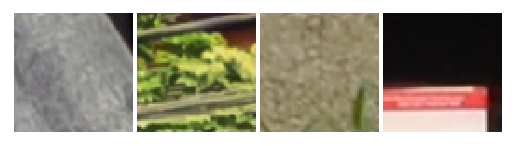

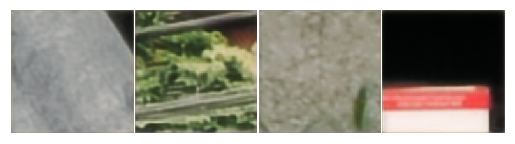

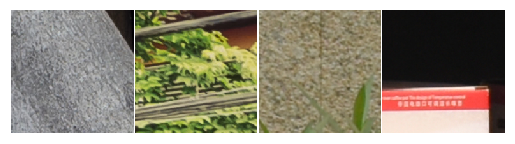


Batch 20/160, generator loss 2.000328302383423, discriminator loss 1.337477445602417
Batch 40/160, generator loss 1.8773771524429321, discriminator loss 1.4276158809661865
Batch 60/160, generator loss 3.0450797080993652, discriminator loss 1.255405068397522
Batch 80/160, generator loss 1.5816570520401, discriminator loss 1.2545911073684692
Batch 100/160, generator loss 1.75890052318573, discriminator loss 1.2655757665634155
Batch 120/160, generator loss 1.2762287855148315, discriminator loss 1.3420079946517944
Batch 140/160, generator loss 2.168118953704834, discriminator loss 1.4062012434005737
Batch 160/160, generator loss 2.893775224685669, discriminator loss 1.312025547027588
#2: training loss value = 2.349018020182848 validation loss value = 2.2532713413238525


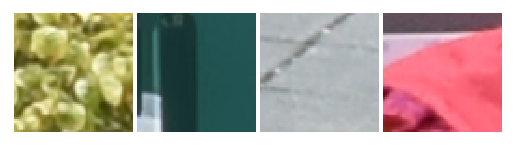

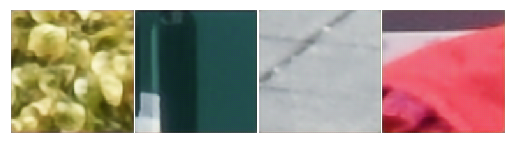

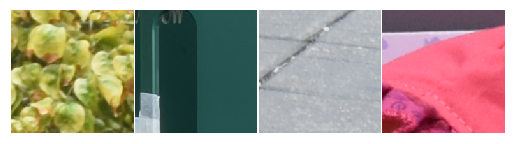


Batch 20/160, generator loss 5.227114677429199, discriminator loss 1.4443408250808716
Batch 40/160, generator loss 3.742655038833618, discriminator loss 1.4986181259155273
Batch 60/160, generator loss 2.997285842895508, discriminator loss 1.4964499473571777
Batch 80/160, generator loss 6.674522399902344, discriminator loss 1.3821921348571777
Batch 100/160, generator loss 2.7924835681915283, discriminator loss 1.406380295753479
Batch 120/160, generator loss 5.456846237182617, discriminator loss 1.6033906936645508
Batch 140/160, generator loss 4.11536169052124, discriminator loss 1.4964672327041626
Batch 160/160, generator loss 6.245953559875488, discriminator loss 1.466206431388855
#3: training loss value = 4.523873680830002 validation loss value = 4.352379584312439


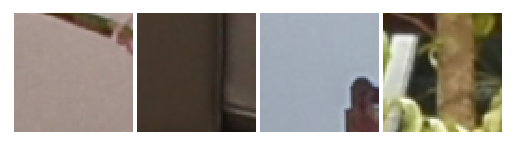

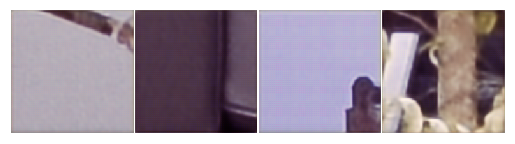

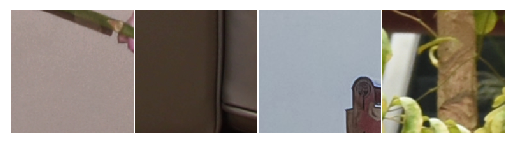


Batch 20/160, generator loss 2.0566086769104004, discriminator loss 1.376956582069397
Batch 40/160, generator loss 3.3488032817840576, discriminator loss 1.3588999509811401
Batch 60/160, generator loss 4.65852165222168, discriminator loss 1.4063838720321655
Batch 80/160, generator loss 5.4837188720703125, discriminator loss 1.406383752822876
Batch 100/160, generator loss 7.340540885925293, discriminator loss 1.4063838720321655
Batch 120/160, generator loss 2.7333807945251465, discriminator loss 1.4063838720321655
Batch 140/160, generator loss 4.781063556671143, discriminator loss 1.4062175750732422
Batch 160/160, generator loss 3.310666084289551, discriminator loss 1.4063838720321655
#4: training loss value = 3.949860353767872 validation loss value = 3.61687470972538


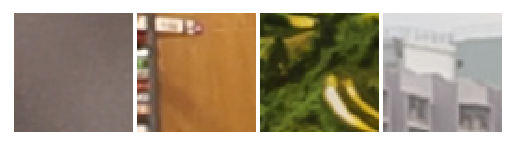

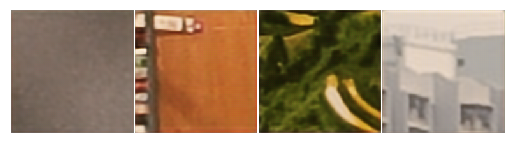

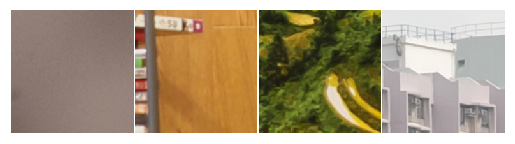


Batch 20/160, generator loss 2.1722095012664795, discriminator loss 1.4063838720321655
Batch 40/160, generator loss 3.345053195953369, discriminator loss 1.4063838720321655
Batch 60/160, generator loss 2.723966121673584, discriminator loss 1.4063838720321655
Batch 80/160, generator loss 5.455820083618164, discriminator loss 1.4063838720321655
Batch 100/160, generator loss 6.478501796722412, discriminator loss 1.4051955938339233
Batch 120/160, generator loss 4.125897407531738, discriminator loss 1.4050049781799316
Batch 140/160, generator loss 3.483598470687866, discriminator loss 1.436252474784851
Batch 160/160, generator loss 14.67388916015625, discriminator loss 1.4063823223114014
#5: training loss value = 4.023680122196675 validation loss value = 4.0856380879879


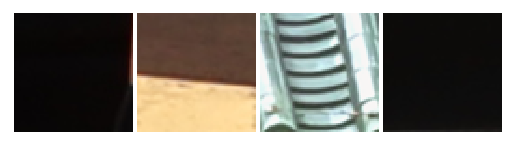

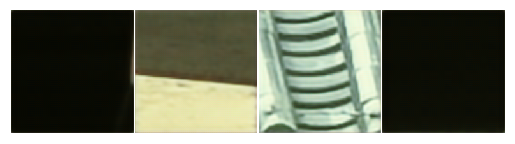

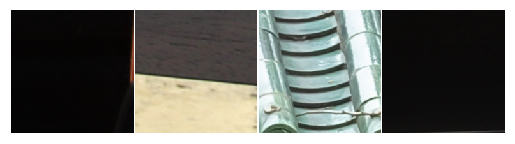


Batch 20/160, generator loss 5.723144054412842, discriminator loss 1.3118661642074585
Batch 40/160, generator loss 7.20618200302124, discriminator loss 1.312313437461853
Batch 60/160, generator loss 4.9183244705200195, discriminator loss 1.3577511310577393
Batch 80/160, generator loss 3.4807589054107666, discriminator loss 1.311994194984436
Batch 100/160, generator loss 3.3723108768463135, discriminator loss 1.4364126920700073
Batch 120/160, generator loss 3.050745725631714, discriminator loss 1.264022707939148
Batch 140/160, generator loss 2.4863507747650146, discriminator loss 1.331626296043396
Batch 160/160, generator loss 5.055539131164551, discriminator loss 1.4063838720321655
#6: training loss value = 3.870571803301573 validation loss value = 3.755816379189491


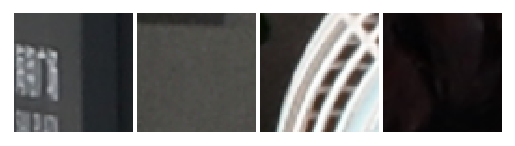

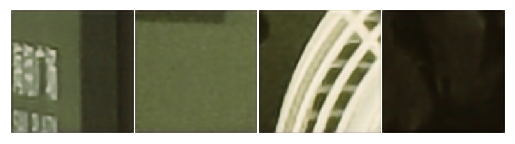

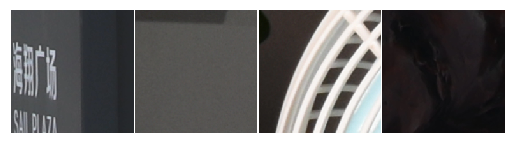


Batch 20/160, generator loss 3.4105851650238037, discriminator loss 1.214562177658081
Batch 40/160, generator loss 4.477657318115234, discriminator loss 1.3114831447601318
Batch 60/160, generator loss 2.697216272354126, discriminator loss 1.2164411544799805
Batch 80/160, generator loss 4.241237163543701, discriminator loss 1.3114449977874756
Batch 100/160, generator loss 3.168931007385254, discriminator loss 1.3591243028640747
Batch 120/160, generator loss 3.4691009521484375, discriminator loss 1.3106616735458374
Batch 140/160, generator loss 2.955721378326416, discriminator loss 1.3588978052139282
Batch 160/160, generator loss 3.398422956466675, discriminator loss 1.3714860677719116
#7: training loss value = 3.7171117030084133 validation loss value = 3.441030091047287


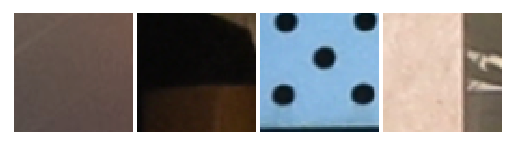

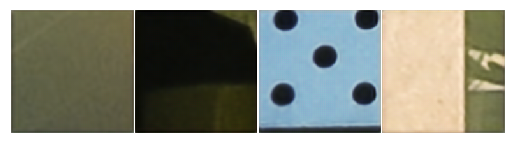

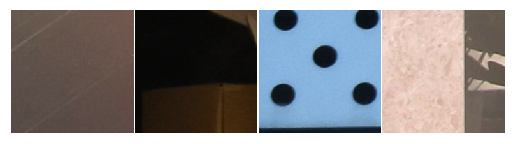


Batch 20/160, generator loss 3.196884870529175, discriminator loss 1.3116114139556885
Batch 40/160, generator loss 6.663902759552002, discriminator loss 1.268156886100769
Batch 60/160, generator loss 3.302316665649414, discriminator loss 1.4063838720321655
Batch 80/160, generator loss 4.41618013381958, discriminator loss 1.391729474067688
Batch 100/160, generator loss 3.823125123977661, discriminator loss 1.1689610481262207
Batch 120/160, generator loss 3.6110711097717285, discriminator loss 1.3540127277374268
Batch 140/160, generator loss 1.990506649017334, discriminator loss 1.3586668968200684
Batch 160/160, generator loss 2.100095510482788, discriminator loss 1.2164411544799805
#8: training loss value = 3.4670339532196524 validation loss value = 3.1845510214567185


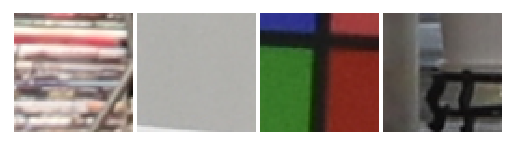

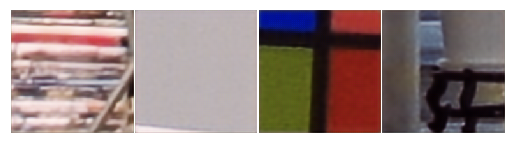

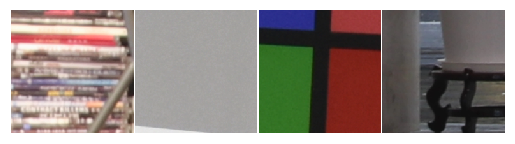


Batch 20/160, generator loss 2.826228141784668, discriminator loss 1.151666283607483
Batch 40/160, generator loss 2.7475202083587646, discriminator loss 1.3589606285095215
Batch 60/160, generator loss 5.155383110046387, discriminator loss 1.213096261024475
Batch 80/160, generator loss 2.9338223934173584, discriminator loss 1.263486385345459
Batch 100/160, generator loss 3.7866013050079346, discriminator loss 1.215006947517395
Batch 120/160, generator loss 3.414433479309082, discriminator loss 1.4364124536514282
Batch 140/160, generator loss 2.738147735595703, discriminator loss 1.3119970560073853
Batch 160/160, generator loss 6.286348819732666, discriminator loss 1.3114124536514282
#9: training loss value = 3.3933949515223505 validation loss value = 3.624503546953201


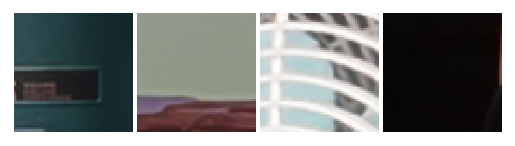

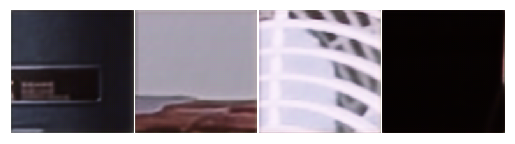

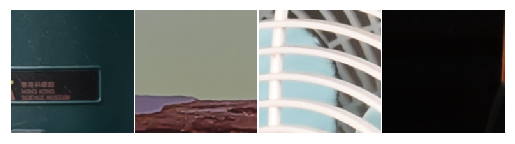


Batch 20/160, generator loss 3.812544107437134, discriminator loss 1.212522268295288
Batch 40/160, generator loss 5.281373023986816, discriminator loss 1.3209940195083618
Batch 60/160, generator loss 4.433437824249268, discriminator loss 1.293911337852478
Batch 80/160, generator loss 2.387737274169922, discriminator loss 1.5356265306472778
Batch 100/160, generator loss 1.7012743949890137, discriminator loss 1.3114125728607178
Batch 120/160, generator loss 3.399940252304077, discriminator loss 1.1163064241409302
Batch 140/160, generator loss 3.0797464847564697, discriminator loss 1.1978527307510376
Batch 160/160, generator loss 3.5897653102874756, discriminator loss 1.1214698553085327
#10: training loss value = 3.5573786966502667 validation loss value = 3.277380493283272


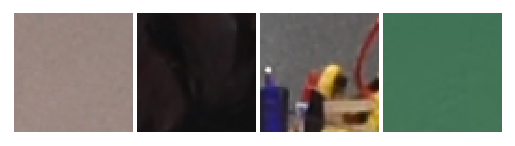

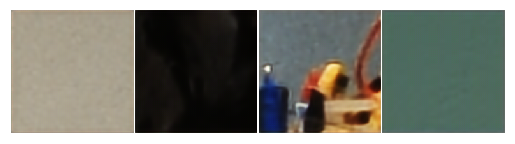

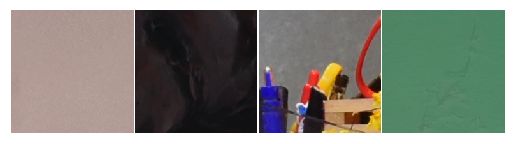


Batch 20/160, generator loss 5.589578151702881, discriminator loss 1.265299916267395
Batch 40/160, generator loss 3.5903124809265137, discriminator loss 1.2639225721359253
Batch 60/160, generator loss 2.949805974960327, discriminator loss 1.1222137212753296
Batch 80/160, generator loss 4.1044721603393555, discriminator loss 1.1900889873504639
Batch 100/160, generator loss 3.001115322113037, discriminator loss 1.2675739526748657
Batch 120/160, generator loss 3.778080701828003, discriminator loss 1.2454428672790527
Batch 140/160, generator loss 3.0029852390289307, discriminator loss 1.075239896774292
Batch 160/160, generator loss 3.386592388153076, discriminator loss 1.31564462184906
#11: training loss value = 3.3636834770441055 validation loss value = 3.2120420813560484


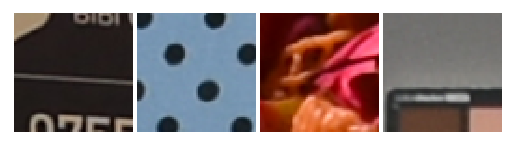

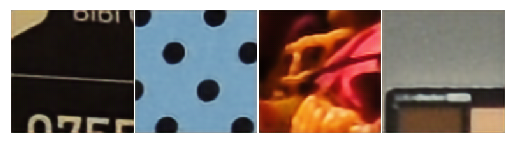

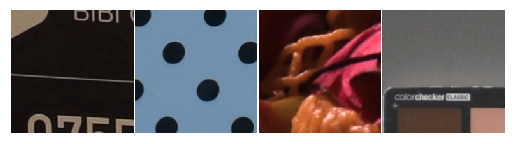


Batch 20/160, generator loss 2.1943368911743164, discriminator loss 1.320947527885437
Batch 40/160, generator loss 5.067920684814453, discriminator loss 1.3669023513793945
Batch 60/160, generator loss 2.531789779663086, discriminator loss 1.2748435735702515
Batch 80/160, generator loss 3.7357091903686523, discriminator loss 1.1818244457244873
Batch 100/160, generator loss 3.6992270946502686, discriminator loss 1.1815787553787231
Batch 120/160, generator loss 3.3068642616271973, discriminator loss 1.0264984369277954
Batch 140/160, generator loss 1.873154878616333, discriminator loss 1.4063838720321655
Batch 160/160, generator loss 2.4890472888946533, discriminator loss 1.3114193677902222
#12: training loss value = 3.1703094013035296 validation loss value = 3.235066345334053


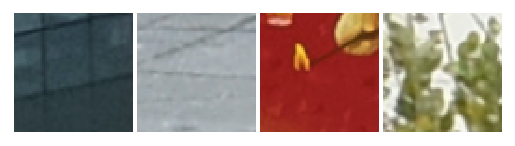

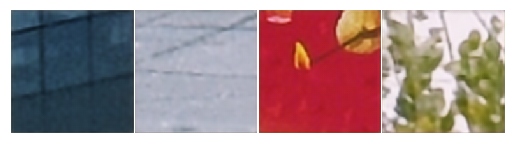

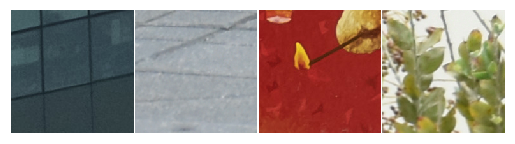


Batch 20/160, generator loss 3.8901925086975098, discriminator loss 1.243491291999817
Batch 40/160, generator loss 6.430466651916504, discriminator loss 1.2639355659484863
Batch 60/160, generator loss 2.3430614471435547, discriminator loss 1.3114124536514282
Batch 80/160, generator loss 4.032960891723633, discriminator loss 1.1051946878433228
Batch 100/160, generator loss 4.241089344024658, discriminator loss 1.026759147644043
Batch 120/160, generator loss 1.9076716899871826, discriminator loss 1.3588436841964722
Batch 140/160, generator loss 2.1663219928741455, discriminator loss 1.3114124536514282
Batch 160/160, generator loss 2.003237724304199, discriminator loss 1.1214698553085327
#13: training loss value = 3.4436924874782564 validation loss value = 3.2112662345170975


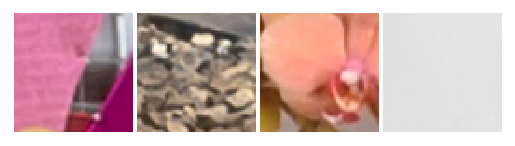

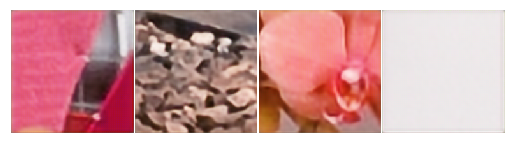

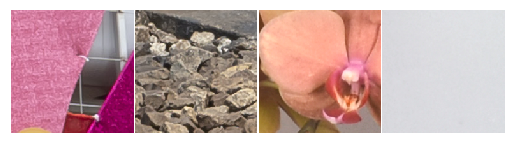


Batch 20/160, generator loss 4.20102596282959, discriminator loss 1.1199208498001099
Batch 40/160, generator loss 2.2164947986602783, discriminator loss 1.1040118932724
Batch 60/160, generator loss 5.42490816116333, discriminator loss 1.0714844465255737
Batch 80/160, generator loss 3.1198742389678955, discriminator loss 1.0264984369277954
Batch 100/160, generator loss 6.178611755371094, discriminator loss 1.0506755113601685
Batch 120/160, generator loss 2.4611847400665283, discriminator loss 1.0264984369277954
Batch 140/160, generator loss 1.9793347120285034, discriminator loss 1.3588981628417969
Batch 160/160, generator loss 2.593724012374878, discriminator loss 1.0264984369277954
#14: training loss value = 3.248231452703476 validation loss value = 3.212086498737335


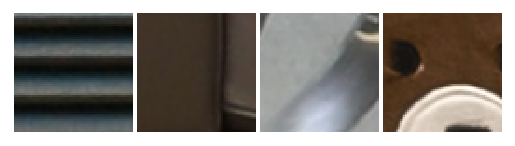

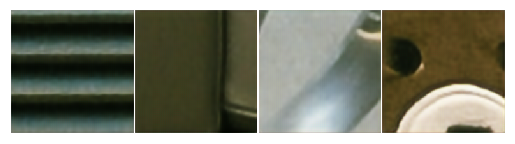

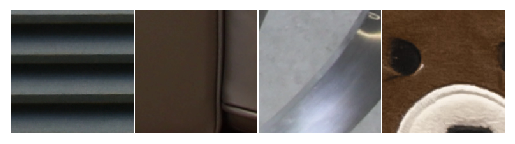


Batch 20/160, generator loss 2.5357513427734375, discriminator loss 1.2465115785598755
Batch 40/160, generator loss 2.2537269592285156, discriminator loss 1.1040127277374268
Batch 60/160, generator loss 2.518744945526123, discriminator loss 1.226016640663147
Batch 80/160, generator loss 1.883449673652649, discriminator loss 1.1509267091751099
Batch 100/160, generator loss 2.031747579574585, discriminator loss 1.2939554452896118
Batch 120/160, generator loss 2.885114908218384, discriminator loss 1.0264984369277954
Batch 140/160, generator loss 1.9633575677871704, discriminator loss 1.2639268636703491
Batch 160/160, generator loss 2.6233069896698, discriminator loss 1.4060341119766235
#15: training loss value = 3.18596253618598 validation loss value = 3.0863626092672347


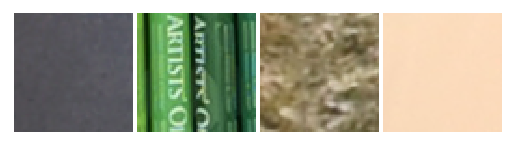

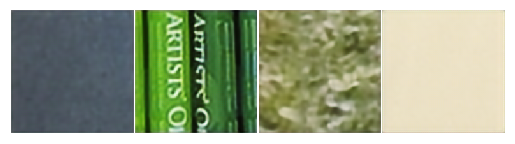

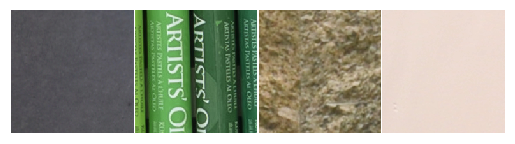


Batch 20/160, generator loss 6.142704010009766, discriminator loss 1.4063795804977417
Batch 40/160, generator loss 3.338054895401001, discriminator loss 1.27432119846344
Batch 60/160, generator loss 4.218780994415283, discriminator loss 1.323984146118164
Batch 80/160, generator loss 3.1317684650421143, discriminator loss 1.4061297178268433
Batch 100/160, generator loss 3.8866536617279053, discriminator loss 1.202226996421814
Batch 120/160, generator loss 2.8676695823669434, discriminator loss 1.0390450954437256
Batch 140/160, generator loss 2.823812246322632, discriminator loss 1.1689554452896118
Batch 160/160, generator loss 4.211854934692383, discriminator loss 1.586554765701294
#16: training loss value = 3.1562669299542905 validation loss value = 3.074417272210121


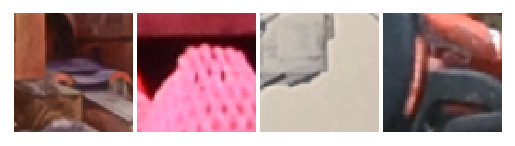

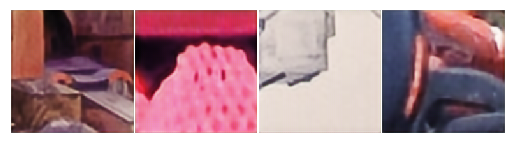

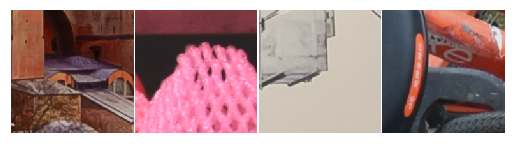


Batch 20/160, generator loss 2.923708915710449, discriminator loss 1.1214690208435059
Batch 40/160, generator loss 2.6669766902923584, discriminator loss 1.073984146118164
Batch 60/160, generator loss 2.8322672843933105, discriminator loss 1.1214886903762817
Batch 80/160, generator loss 2.5066306591033936, discriminator loss 1.0739840269088745
Batch 100/160, generator loss 2.140850067138672, discriminator loss 1.1673780679702759
Batch 120/160, generator loss 2.4575066566467285, discriminator loss 1.0264984369277954
Batch 140/160, generator loss 2.8137741088867188, discriminator loss 1.1689573526382446
Batch 160/160, generator loss 7.807214260101318, discriminator loss 1.0264984369277954
#17: training loss value = 3.1621107786893843 validation loss value = 3.2187140762805937


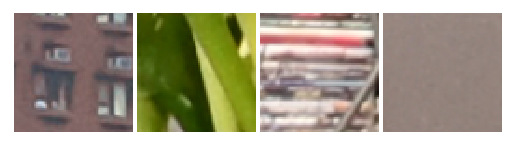

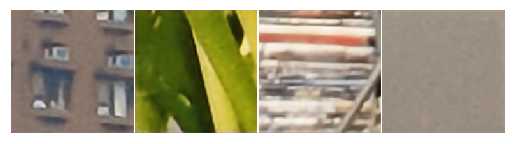

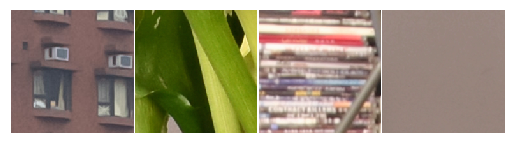


Batch 20/160, generator loss 1.6535756587982178, discriminator loss 1.0264984369277954
Batch 40/160, generator loss 2.5084095001220703, discriminator loss 1.1038563251495361
Batch 60/160, generator loss 3.453338146209717, discriminator loss 1.032882809638977
Batch 80/160, generator loss 2.703460454940796, discriminator loss 1.0264984369277954
Batch 100/160, generator loss 3.8769428730010986, discriminator loss 1.0264984369277954
Batch 120/160, generator loss 2.5641980171203613, discriminator loss 1.569098711013794
Batch 140/160, generator loss 2.824834108352661, discriminator loss 1.1214463710784912
Batch 160/160, generator loss 4.412542343139648, discriminator loss 1.3106778860092163
#18: training loss value = 3.1202064760029318 validation loss value = 2.979625681042671


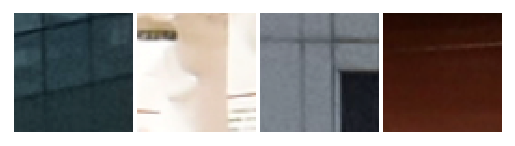

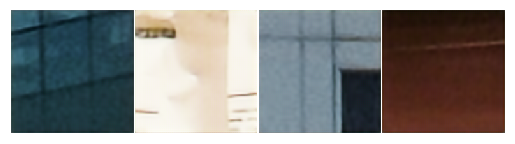

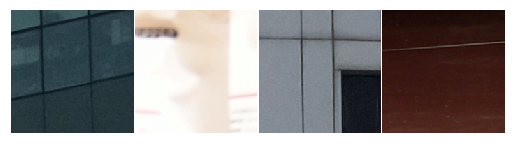


Batch 20/160, generator loss 3.736487865447998, discriminator loss 1.1040226221084595
Batch 40/160, generator loss 4.659434795379639, discriminator loss 1.0264984369277954
Batch 60/160, generator loss 2.7877237796783447, discriminator loss 1.1040130853652954
Batch 80/160, generator loss 2.6841630935668945, discriminator loss 1.2311604022979736
Batch 100/160, generator loss 3.3178584575653076, discriminator loss 1.0264984369277954
Batch 120/160, generator loss 2.35125732421875, discriminator loss 1.0264984369277954
Batch 140/160, generator loss 3.589294910430908, discriminator loss 1.073984146118164
Batch 160/160, generator loss 2.1945295333862305, discriminator loss 1.1214698553085327
#19: training loss value = 3.0147909514605997 validation loss value = 2.919471579790115


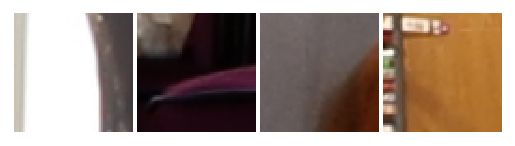

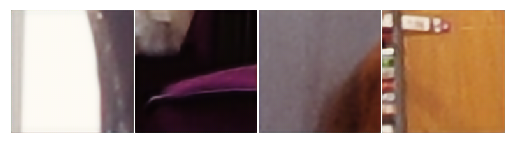

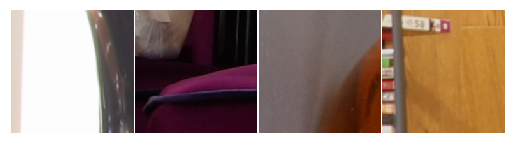


Batch 20/160, generator loss 2.553868293762207, discriminator loss 1.073984146118164
Batch 40/160, generator loss 4.320030212402344, discriminator loss 1.0264984369277954
Batch 60/160, generator loss 2.7367208003997803, discriminator loss 1.1002360582351685
Batch 80/160, generator loss 4.362337112426758, discriminator loss 1.0264984369277954
Batch 100/160, generator loss 3.077012777328491, discriminator loss 1.3414504528045654
Batch 120/160, generator loss 4.0444793701171875, discriminator loss 1.2639431953430176
Batch 140/160, generator loss 2.1467125415802, discriminator loss 1.169183373451233
Batch 160/160, generator loss 4.825246810913086, discriminator loss 1.0264984369277954
#20: training loss value = 3.133365714550018 validation loss value = 3.2847449481487274


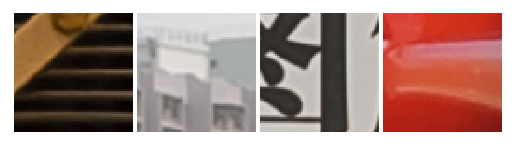

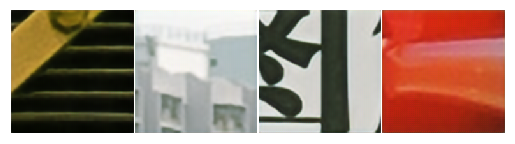

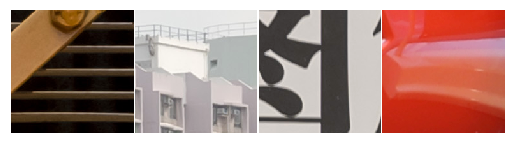

In [3]:
cropped_dir = "./cropped_images"
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

iters, train_losses, val_losses = train_prototype(train_dl, val_dl, num_epochs=20, learning_rate=0.001)

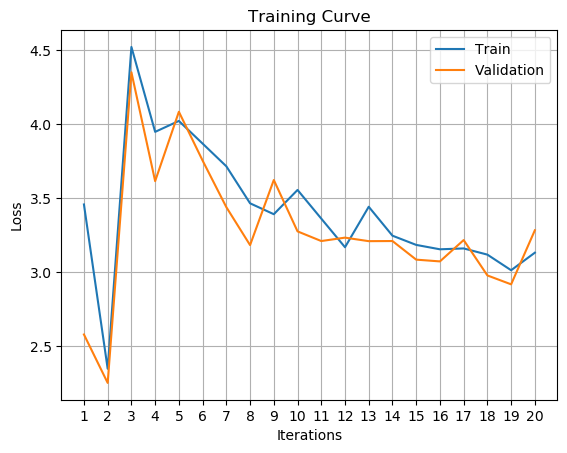

In [4]:
plt.title("Training Curve")
plt.plot(iters, train_losses, label="Train")
plt.plot(iters, val_losses, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.xticks(range(iters[0], iters[-1]+1))
plt.legend()
plt.grid()
plt.show()

In [5]:
#For Testing The Model

def test_prototype_model(test_dl, upscale_model, discriminator_model, criterion):
    device = next(upscale_model.parameters()).device
    
    upscale_model.eval()
    discriminator_model.eval()
    
    test_loss = 0.0
    num_batches = len(test_dl)
    
    with torch.no_grad():
        for inputs_lr, targets_hr in test_dl:
            inputs_lr = inputs_lr.to(device)
            targets_hr = targets_hr.to(device)
            
            generated_hr = upscale_model(inputs_lr)
            generated_outputs = discriminator_model(generated_hr)
            
            loss = criterion(generated_hr, targets_hr, generated_outputs)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / num_batches
    print(f"Average Test Loss: {avg_test_loss}")


In [6]:
#Running the Test Function:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dl, val_dl, test_dl = get_train_val_test_dataloaders(8)

best_val = iters[2:][np.argmin(val_losses[2:])]
print("Best validation loss: epoch", best_val)
print()

discriminator_model = torch.load(f"prototype_models/model_{best_val}_d.pth").to(device)
upscaling_model = torch.load(f"prototype_models/model_{best_val}_g.pth").to(device)

print("Testing loss, consistent with training:")
criterion = CombinedLoss(0.1, 1.0, 1.0, 0.5, 100.0, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()

print("Testing loss, consistent with baseline evaluation:")
criterion = CombinedLoss(0.0, 1.0, 1.0, 1.0, 4.0, device=device)
test_prototype_model(test_dl,upscaling_model,discriminator_model,criterion)
print()


Best validation loss: epoch 19

Testing loss, consistent with training:
Average Test Loss: 3.339271017149383

Testing loss, consistent with baseline evaluation:
Average Test Loss: 3.8766731608147715

